In [10]:
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf

from IPython import display
from matplotlib import pyplot as plt
from typing import Dict, List, Optional, Sequence, Tuple

import os

In [11]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Sampling rate for audio playback
_SAMPLING_RATE = 16000

In [12]:
data_dir = pathlib.Path('../raw_data/midi_chopin_format_0_dataset/')
filenames = glob.glob(str(data_dir/'*.mid*'))
print('Number of files:', len(filenames))

Number of files: 131


### Process a MIDI file

In [13]:
sample_file = filenames[1]
print(sample_file)

../raw_data/midi_chopin_format_0_dataset/chpn_op25_e12_format0.mid


In [14]:
pm = pretty_midi.PrettyMIDI(sample_file)

In [15]:
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  # Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)

In [16]:
#display_audio(pm)

In [17]:
print('Number of instruments:', len(pm.instruments))
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print('Instrument name:', instrument_name)

Number of instruments: 1
Instrument name: Bright Acoustic Piano


In [18]:
#pm2 = pretty_midi.PrettyMIDI('../raw_data/midi_format_1/3123a_berceuse_(c)smythe.mid')

In [19]:
#print('Number of instruments:', len(pm2.instruments))
#instrument = pm2.instruments[0]
#instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
#print('Instrument name:', instrument_name)

### Extract notes

In [20]:
for i, note in enumerate(instrument.notes[:10]):
  note_name = pretty_midi.note_number_to_name(note.pitch)
  duration = note.end - note.start
  print(f'{i}: pitch={note.pitch}, note_name={note_name},'
        f' duration={duration:.4f}')

0: pitch=36, note_name=C2, duration=0.1055
1: pitch=51, note_name=D#3, duration=0.1055
2: pitch=43, note_name=G2, duration=0.1033
3: pitch=55, note_name=G3, duration=0.1033
4: pitch=48, note_name=C3, duration=0.1009
5: pitch=63, note_name=D#4, duration=0.1009
6: pitch=48, note_name=C3, duration=0.0987
7: pitch=63, note_name=D#4, duration=0.0987
8: pitch=55, note_name=G3, duration=0.0973
9: pitch=67, note_name=G4, duration=0.0973


In [21]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(midi_file)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list)

  # Sort the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [22]:
raw_notes = midi_to_notes(sample_file)
raw_notes.head()

,pitch,start,end,step,duration
0,36,0.000000,0.105506,0.000000,0.105506
1,51,0.000000,0.105506,0.000000,0.105506
2,43,0.106386,0.209694,0.106386,0.103308
3,55,0.106386,0.209694,0.000000,0.103308
4,48,0.210557,0.311413,0.104170,0.100856


In [23]:
get_note_names = np.vectorize(pretty_midi.note_number_to_name)
sample_note_names = get_note_names(raw_notes['pitch'])
sample_note_names[:10]

array(['C2', 'D#3', 'G2', 'G3', 'C3', 'D#4', 'C3', 'D#4', 'G3', 'G4'],
      dtype='<U3')

In [24]:
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
  if count:
    title = f'First {count} notes'
  else:
    title = f'Whole track'
    count = len(notes['pitch'])
  plt.figure(figsize=(20, 4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  _ = plt.title(title)

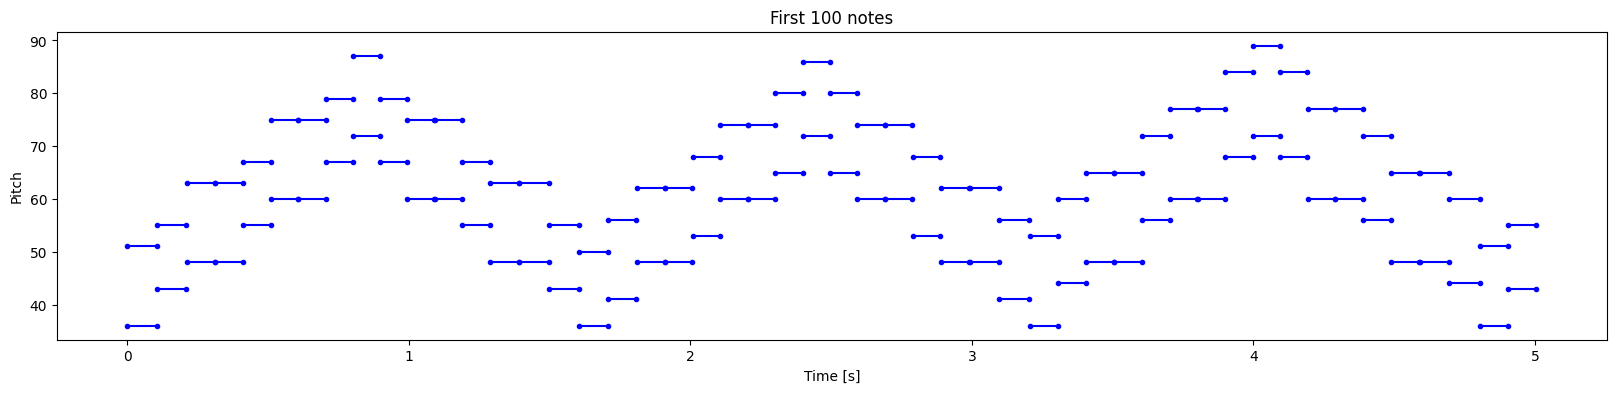

In [25]:
plot_piano_roll(raw_notes, count=100)


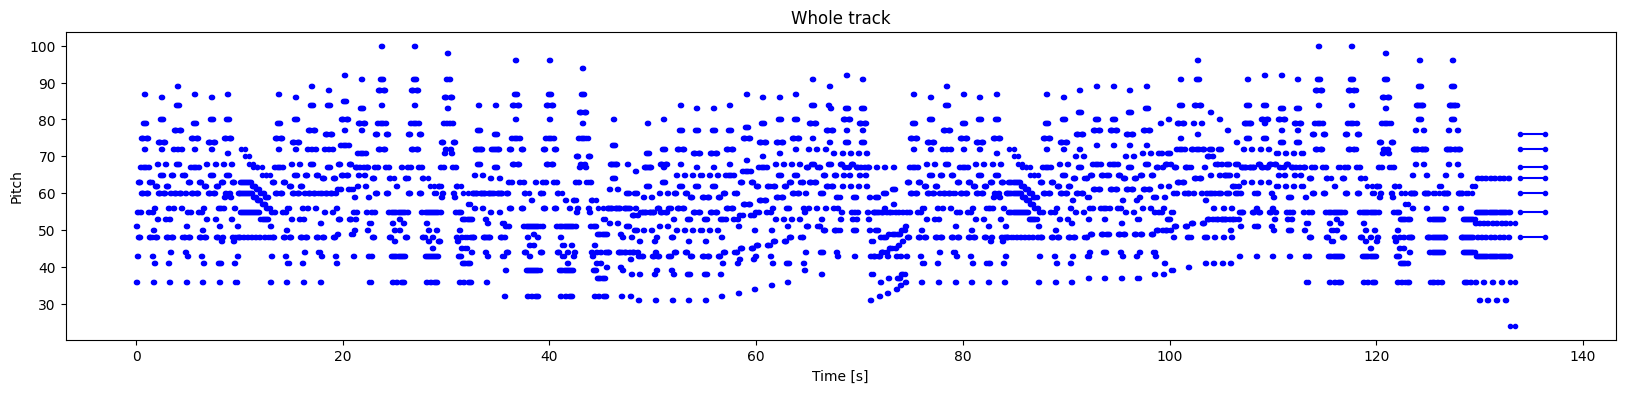

In [26]:
plot_piano_roll(raw_notes)


In [27]:
def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5):
  plt.figure(figsize=[15, 5])
  plt.subplot(1, 3, 1)
  sns.histplot(notes, x="pitch", bins=20)

  plt.subplot(1, 3, 2)
  max_step = np.percentile(notes['step'], 100 - drop_percentile)
  sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))

  plt.subplot(1, 3, 3)
  max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
  sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))

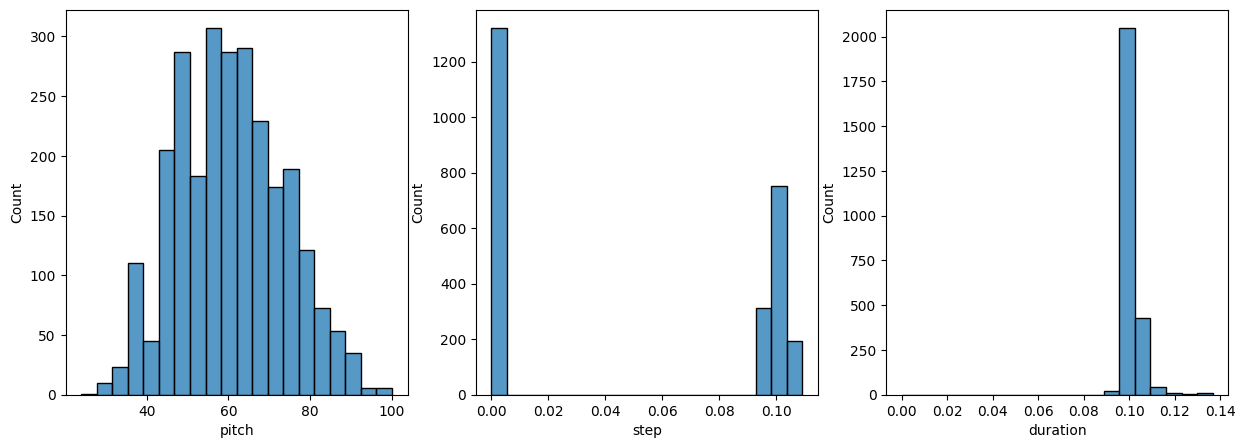

In [28]:
plot_distributions(raw_notes)


### Create a MIDI file

In [29]:
def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str, 
  instrument_name: str,
  velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

In [30]:
example_file = 'example.midi'
example_pm = notes_to_midi(
    raw_notes, out_file=example_file, instrument_name=instrument_name)

In [31]:
#display_audio(example_pm)

### Create the training dataset

In [32]:
len(filenames)

131

In [33]:
num_files = len(filenames)
all_notes = []
for f in filenames[:num_files]:
    try:
        notes = midi_to_notes(f)
        all_notes.append(notes)
    except OSError:
        print(f'File with error: {f}')

all_notes = pd.concat(all_notes)

/Users/aurelie_emma/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/pretty_midi/pretty_midi.py:97: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


In [34]:
n_notes = len(all_notes)
print('Number of notes parsed:', n_notes)

Number of notes parsed: 260589


In [35]:
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)

In [36]:
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

TensorSpec(shape=(3,), dtype=tf.float64, name=None)

In [37]:
def create_sequences(
    dataset: tf.data.Dataset, 
    seq_length: int,
    vocab_size = 128,
) -> tf.data.Dataset:
  """Returns TF Dataset of sequence and label examples."""
  seq_length = seq_length+1

  # Take 1 extra for the labels
  windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

  # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)

  # Normalize note pitch
  def scale_pitch(x):
    x = x/[vocab_size,1.0,1.0]
    return x

  # Split the labels
  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

    return scale_pitch(inputs), labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
seq_length = 50
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec

(TensorSpec(shape=(100, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(), dtype=tf.float64, name=None)})

In [ ]:
for seq, target in seq_ds.take(1):
  print('sequence shape:', seq.shape)
  print('sequence elements (first 10):', seq[0: 10])
  print()
  print('target:', target)

sequence shape: (100, 3)
sequence elements (first 10): tf.Tensor(
[[0.3828125  0.         0.4031175 ]
 [0.6015625  0.         0.60467625]
 [0.4375     0.4031175  0.411173  ]
 [0.5703125  0.20155875 0.20961425]
 [0.53125    0.20961425 1.5375    ]
 [0.5078125  0.         1.5375    ]
 [0.4765625  0.         1.5375    ]
 [0.4375     0.4192285  0.36075965]
 [0.4375     0.379747   0.35403745]
 [0.4375     0.372671   0.34756082]], shape=(10, 3), dtype=float64)

target: {'pitch': <tf.Tensor: shape=(), dtype=float64, numpy=61.0>, 'step': <tf.Tensor: shape=(), dtype=float64, numpy=0.0>, 'duration': <tf.Tensor: shape=(), dtype=float64, numpy=0.3979834999999987>}


In [63]:
batch_size = 32
buffer_size = n_notes - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

In [64]:
train_ds.element_spec

(TensorSpec(shape=(32, 100, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(32,), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(32,), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(32,), dtype=tf.float64, name=None)})

### Create and train the baseline model

In [42]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

In [34]:
input_shape = (seq_length, 3)
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(128)(inputs)

outputs = {
  'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
  'step': tf.keras.layers.Dense(1, name='step')(x),
  'duration': tf.keras.layers.Dense(1, name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)

loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'step': mse_with_positive_pressure,
      'duration': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 25, 3)]      0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 128)          67584       ['input_1[0][0]']                
                                                                                                  
 duration (Dense)               (None, 1)            129         ['lstm[0][0]']                   
                                                                                                  
 pitch (Dense)                  (None, 128)          16512       ['lstm[0][0]']                   
                                                                                              

In [35]:
losses = model.evaluate(train_ds, return_dict=True)
losses

2022-12-06 21:05:30.341068: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 205621 of 260564


     34/Unknown - 13s 5ms/step - loss: 5.1344 - duration_loss: 0.2692 - pitch_loss: 4.8432 - step_loss: 0.0221

2022-12-06 21:05:32.959671: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


8142/8142 [==============================] - 51s 5ms/step - loss: 5.1090 - duration_loss: 0.2394 - pitch_loss: 4.8441 - step_loss: 0.0256


{'loss': 5.108992576599121,
 'duration_loss': 0.2393566071987152,
 'pitch_loss': 4.844067096710205,
 'step_loss': 0.025562888011336327}

In [36]:
model.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.05,
        'step': 1.0,
        'duration':1.0,
    },
    optimizer=optimizer,
)

In [37]:
model.evaluate(train_ds, return_dict=True)

8142/8142 [==============================] - 37s 4ms/step - loss: 0.5071 - duration_loss: 0.2394 - pitch_loss: 4.8441 - step_loss: 0.0256


{'loss': 0.5071237087249756,
 'duration_loss': 0.2393566071987152,
 'pitch_loss': 4.844067096710205,
 'step_loss': 0.025562888011336327}

In [38]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

In [39]:
%%time
epochs = 100

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/100
8142/8142 [==============================] - 96s 12ms/step - loss: 0.3395 - duration_loss: 0.1225 - pitch_loss: 3.8874 - step_loss: 0.0227
Epoch 2/100
8142/8142 [==============================] - 95s 12ms/step - loss: 0.3288 - duration_loss: 0.1181 - pitch_loss: 3.7951 - step_loss: 0.0209
Epoch 3/100
8142/8142 [==============================] - 91s 11ms/step - loss: 0.3234 - duration_loss: 0.1158 - pitch_loss: 3.7420 - step_loss: 0.0205
Epoch 4/100
8142/8142 [==============================] - 87s 11ms/step - loss: 0.3195 - duration_loss: 0.1138 - pitch_loss: 3.7149 - step_loss: 0.0199
Epoch 5/100
8142/8142 [==============================] - 83s 10ms/step - loss: 0.3172 - duration_loss: 0.1127 - pitch_loss: 3.6932 - step_loss: 0.0198
Epoch 6/100
8142/8142 [==============================] - 82s 10ms/step - loss: 0.3141 - duration_loss: 0.1105 - pitch_loss: 3.6780 - step_loss: 0.0197
Epoch 7/100
8142/8142 [==============================] - 83s 10ms/step - loss: 0.3122 - durati

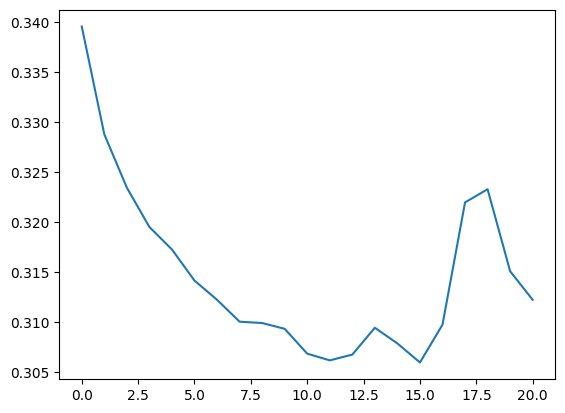

In [40]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

In [41]:
history.history

{'loss': [0.339527428150177,
  0.32875320315361023,
  0.3234255313873291,
  0.3194950520992279,
  0.31724855303764343,
  0.3141408860683441,
  0.31222400069236755,
  0.3100354075431824,
  0.30990102887153625,
  0.30932503938674927,
  0.30684149265289307,
  0.30617088079452515,
  0.30674734711647034,
  0.30943024158477783,
  0.3078618049621582,
  0.30595993995666504,
  0.30973708629608154,
  0.3219514787197113,
  0.3232685625553131,
  0.3150765895843506,
  0.31221604347229004],
 'duration_loss': [0.12247197329998016,
  0.11806527525186539,
  0.11581291258335114,
  0.11384030431509018,
  0.11274202913045883,
  0.11050641536712646,
  0.10909249633550644,
  0.10780834406614304,
  0.10782676935195923,
  0.1070277988910675,
  0.10567135363817215,
  0.10493823140859604,
  0.10556013137102127,
  0.10705233365297318,
  0.10606357455253601,
  0.10522555559873581,
  0.10722589492797852,
  0.11502671986818314,
  0.11653731018304825,
  0.11219776421785355,
  0.10976403951644897],
 'pitch_loss': [3.

In [42]:
def predict_next_note(
    notes: np.ndarray, 
    keras_model: tf.keras.Model, 
    temperature: float = 1.0) -> int:
  """Generates a note IDs using a trained sequence model."""

  assert temperature > 0

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
  pitch_logits = predictions['pitch']
  step = predictions['step']
  duration = predictions['duration']

  pitch_logits /= temperature
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)

  # `step` and `duration` values should be non-negative
  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)

  return int(pitch), float(step), float(duration)

In [43]:
temperature = 2.0
num_predictions = 120

sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training
# sequences
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
  pitch, step, duration = predict_next_note(input_notes, model, temperature)
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

1/1 [==============================] - 0s 11ms/step


In [44]:
generated_notes.head(10)

,pitch,step,duration,start,end
0,66,0.028016,0.084766,0.028016,0.112782
1,95,1.007450,0.000000,1.035466,1.035466
2,97,0.967412,0.000000,2.002878,2.002878
3,83,1.223296,0.000000,3.226174,3.226174
4,91,1.025722,0.000000,4.251896,4.251896
5,84,1.233646,0.000000,5.485542,5.485542
6,81,1.035110,0.031604,6.520653,6.552257
7,85,1.233188,0.000000,7.753840,7.753840
8,77,1.034538,0.111755,8.788378,8.900133
9,84,1.231351,0.000000,10.019729,10.019729


In [45]:
out_file = 'output.mid'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name)
#display_audio(out_pm)

In [46]:
model_outputs_directory_path = '../raw_data/model_outputs/'
filename = 'tensorflow_baseline_output.mid'
out_pm.write(os.path.join(model_outputs_directory_path, filename))

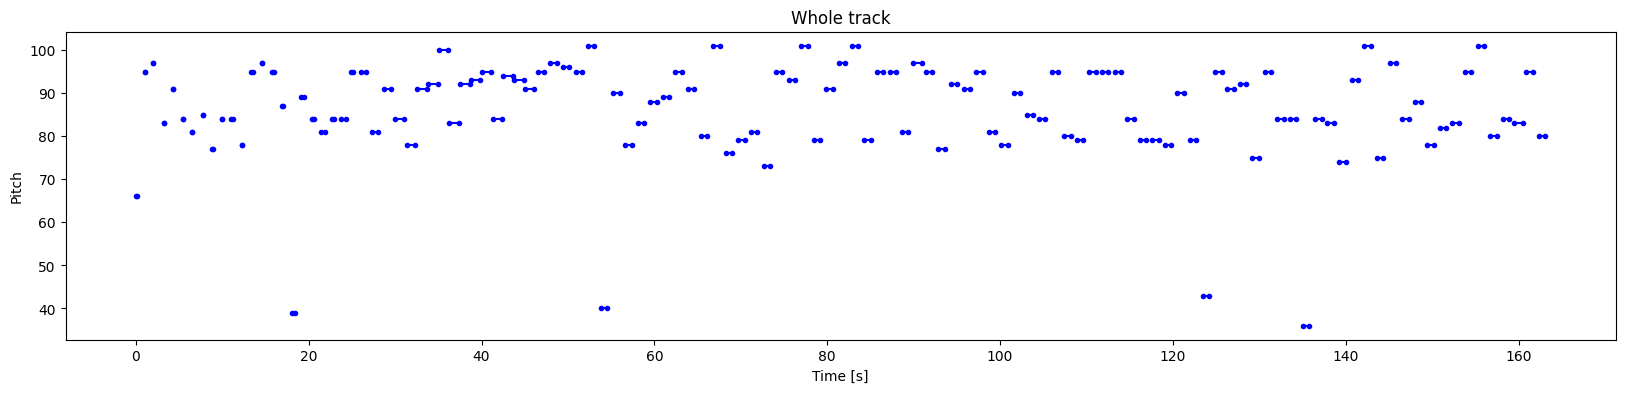

In [47]:
plot_piano_roll(generated_notes)

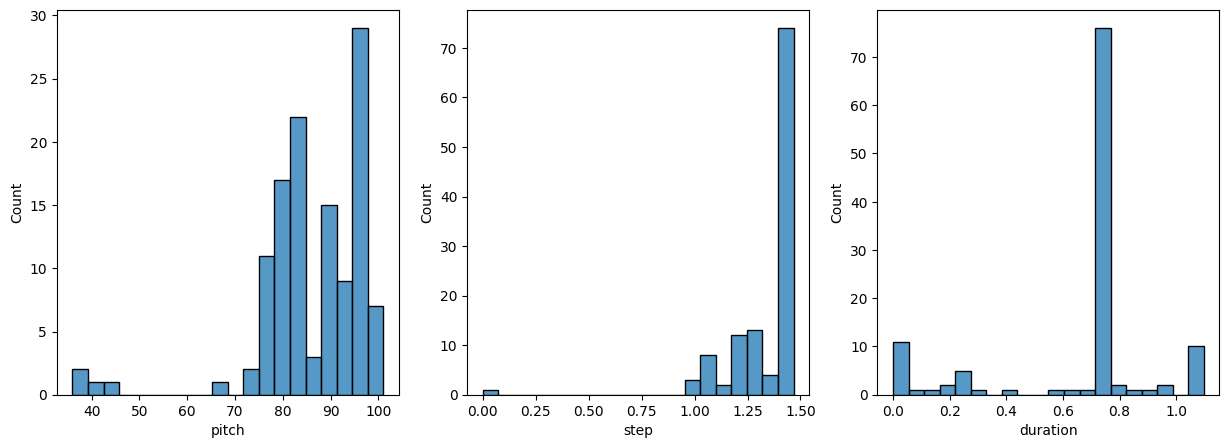

In [48]:
plot_distributions(generated_notes)

### Add 1 attention layer to the model

In [49]:
import sys
sys.path.insert(0,"..")
from model.attention import attention

In [50]:
input_shape = (seq_length, 3)
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x1 = tf.keras.layers.LSTM(128, return_sequences=True)(inputs)
x2 = attention()(x1)

outputs = {
  'pitch': tf.keras.layers.Dense(128, name='pitch')(x2),
  'step': tf.keras.layers.Dense(1, name='step')(x2),
  'duration': tf.keras.layers.Dense(1, name='duration')(x2),
}

model_2 = tf.keras.Model(inputs, outputs)

loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'step': mse_with_positive_pressure,
      'duration': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model_2.compile(loss=loss, optimizer=optimizer)

model_2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 25, 3)]      0           []                               
                                                                                                  
 lstm_1 (LSTM)                  (None, 25, 128)      67584       ['input_2[0][0]']                
                                                                                                  
 attention (attention)          (None, 128)          153         ['lstm_1[0][0]']                 
                                                                                                  
 duration (Dense)               (None, 1)            129         ['attention[0][0]']              
                                                                                            

In [51]:
losses = model_2.evaluate(train_ds, return_dict=True)
losses

8142/8142 [==============================] - 35s 4ms/step - loss: 5.9609 - duration_loss: 1.0719 - pitch_loss: 4.8523 - step_loss: 0.0368


{'loss': 5.960941791534424,
 'duration_loss': 1.0719287395477295,
 'pitch_loss': 4.852267742156982,
 'step_loss': 0.03676209971308708}

In [52]:
model_2.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.05,
        'step': 1.0,
        'duration':1.0,
    },
    optimizer=optimizer,
)

In [53]:
model_2.evaluate(train_ds, return_dict=True)

8142/8142 [==============================] - 36s 4ms/step - loss: 1.3513 - duration_loss: 1.0719 - pitch_loss: 4.8523 - step_loss: 0.0368


{'loss': 1.3513048887252808,
 'duration_loss': 1.0719287395477295,
 'pitch_loss': 4.852267742156982,
 'step_loss': 0.03676209971308708}

In [54]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

In [55]:
%%time
epochs = 100

history_2 = model_2.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/100
8142/8142 [==============================] - 93s 11ms/step - loss: 0.3468 - duration_loss: 0.1288 - pitch_loss: 3.8910 - step_loss: 0.0235
Epoch 2/100
8142/8142 [==============================] - 91s 11ms/step - loss: 0.3338 - duration_loss: 0.1213 - pitch_loss: 3.8113 - step_loss: 0.0219
Epoch 3/100
8142/8142 [==============================] - 93s 11ms/step - loss: 0.3273 - duration_loss: 0.1176 - pitch_loss: 3.7737 - step_loss: 0.0210
Epoch 4/100
8142/8142 [==============================] - 94s 12ms/step - loss: 0.3245 - duration_loss: 0.1164 - pitch_loss: 3.7490 - step_loss: 0.0206
Epoch 5/100
8142/8142 [==============================] - 94s 11ms/step - loss: 0.3211 - duration_loss: 0.1141 - pitch_loss: 3.7309 - step_loss: 0.0205
Epoch 6/100
8142/8142 [==============================] - 94s 12ms/step - loss: 0.3290 - duration_loss: 0.1205 - pitch_loss: 3.7431 - step_loss: 0.0214
Epoch 7/100
8142/8142 [==============================] - 95s 12ms/step - loss: 0.3254 - durati

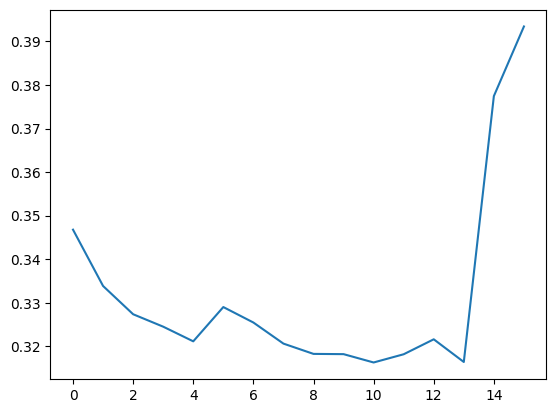

In [56]:
plt.plot(history_2.epoch, history_2.history['loss'], label='total loss')
plt.show()

In [57]:

temperature = 2.0
num_predictions = 120

sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training
# sequences
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes_2 = []
prev_start = 0
for _ in range(num_predictions):
  pitch, step, duration = predict_next_note(input_notes, model_2, temperature)
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes_2.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes_2 = pd.DataFrame(
    generated_notes_2, columns=(*key_order, 'start', 'end'))

1/1 [==============================] - 0s 10ms/step


In [58]:
out_file = 'output.mid'
out_pm = notes_to_midi(
    generated_notes_2, out_file=out_file, instrument_name=instrument_name)
#display_audio(out_pm)

In [59]:
model_outputs_directory_path = '../raw_data/model_outputs/'
filename = 'tensorflow_model_2_output.mid'
out_pm.write(os.path.join(model_outputs_directory_path, filename))

### Add self attention and another LSTM layer

In [49]:
from keras_self_attention import SeqSelfAttention

In [51]:
input_shape = (seq_length, 3)
learning_rate = 0.001

inputs = tf.keras.Input(input_shape)
x1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(inputs)
x2 = SeqSelfAttention(attention_activation='sigmoid')(x1)
x3 = tf.keras.layers.Dropout(0.3)(x2)
x4 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512, return_sequences=True))(x3)
x5 = SeqSelfAttention(attention_activation='sigmoid')(x4)
x6 = tf.keras.layers.Dropout(0.3)(x5)
x7 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512, return_sequences=True))(x6)
x8 = tf.keras.layers.Flatten()(x7)

outputs = {
  'pitch': tf.keras.layers.Dense(128, name='pitch')(x8),
  'step': tf.keras.layers.Dense(1, name='step')(x8),
  'duration': tf.keras.layers.Dense(1, name='duration')(x8),
}

model_3 = tf.keras.Model(inputs, outputs)

loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'step': mse_with_positive_pressure,
      'duration': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model_3.compile(loss=loss, optimizer=optimizer)

model_3.summary()

/Users/aurelie_emma/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 100, 3)]     0           []                               
                                                                                                  
 bidirectional_3 (Bidirectional  (None, 100, 256)    135168      ['input_3[0][0]']                
 )                                                                                                
                                                                                                  
 seq_self_attention_2 (SeqSelfA  (None, 100, 256)    16449       ['bidirectional_3[0][0]']        
 ttention)                                                                                        
                                                                                            

In [52]:
model_3.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.05,
        'step': 1.0,
        'duration':1.0,
    },
    optimizer=optimizer,
)

In [54]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

In [55]:
%%time
epochs = 1

history_3 = model_3.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)

2022-12-07 11:10:33.392814: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 95761 of 260489
2022-12-07 11:10:43.392808: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 191124 of 260489
2022-12-07 11:10:50.509684: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


    371/Unknown - 481s 1s/step - loss: 42816.6289 - duration_loss: 22302.7969 - pitch_loss: 5615.3774 - step_loss: 20233.0410

KeyboardInterrupt: 

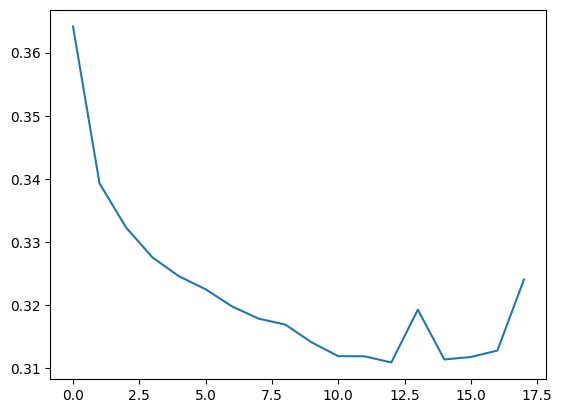

In [ ]:
plt.plot(history_3.epoch, history_3.history['loss'], label='total loss')
plt.show()

In [ ]:
temperature = 2.0
num_predictions = 120

sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training
# sequences
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes_3 = []
prev_start = 0
for _ in range(num_predictions):
  pitch, step, duration = predict_next_note(input_notes, model_3, temperature)
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes_3.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes_3 = pd.DataFrame(
    generated_notes_3, columns=(*key_order, 'start', 'end'))

1/1 [==============================] - 0s 10ms/step


In [ ]:
out_file = 'output.mid'
out_pm = notes_to_midi(
    generated_notes_3, out_file=out_file, instrument_name=instrument_name)
#display_audio(out_pm)

In [ ]:
model_outputs_directory_path = '../raw_data/model_outputs/'
filename = 'tensorflow_model_3_output.mid'
out_pm.write(os.path.join(model_outputs_directory_path, filename))

### Attention exploration

In [65]:
import numpy as np
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from keras.datasets import imdb

In [76]:
input_shape = (seq_length, 3) #sequence length of 50
learning_rate = 0.001

inputs = tf.keras.Input(input_shape)
x1 = Bidirectional(LSTM(256, return_sequences=True))(inputs)
x2 = SeqSelfAttention(attention_activation='sigmoid')(x1)
x3 = tf.keras.layers.Dropout(0.3)(x2)
x4 = LSTM(256)(x3)


outputs = {
  'pitch': tf.keras.layers.Dense(128, activation = 'softmax', name='pitch')(x4),
  'step': tf.keras.layers.Dense(1, name='step')(x4),
  'duration': tf.keras.layers.Dense(1, name='duration')(x4),
}

model = tf.keras.Model(inputs, outputs)

loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      'step': mse_with_positive_pressure,
      'duration': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 100, 3)]     0           []                               
                                                                                                  
 bidirectional_11 (Bidirectiona  (None, 100, 512)    532480      ['input_9[0][0]']                
 l)                                                                                               
                                                                                                  
 seq_self_attention_9 (SeqSelfA  (None, 100, 512)    32833       ['bidirectional_11[0][0]']       
 ttention)                                                                                        
                                                                                            

In [77]:
model.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.05,
        'step': 1.0,
        'duration':1.0,
    },
    optimizer=optimizer,
)

In [78]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
    ]

In [79]:
%%time
epochs = 100

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/100
8140/8140 [==============================] - 2205s 271ms/step - loss: 0.3613 - duration_loss: 0.1382 - pitch_loss: 3.9628 - step_loss: 0.0249
Epoch 2/100
8140/8140 [==============================] - 2228s 274ms/step - loss: 0.3638 - duration_loss: 0.1415 - pitch_loss: 3.9480 - step_loss: 0.0249
Epoch 3/100
5325/8140 [==================>...........] - ETA: 12:49 - loss: 0.3478 - duration_loss: 0.1264 - pitch_loss: 3.9441 - step_loss: 0.0242

KeyboardInterrupt: 

In [ ]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

In [ ]:
temperature = 2.0
num_predictions = 120

sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training
# sequences
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
  pitch, step, duration = predict_next_note(input_notes, model, temperature)
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

In [ ]:
out_file = 'output.mid'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name)
#display_audio(out_pm)

In [ ]:
model_outputs_directory_path = '../raw_data/model_outputs/'
filename = 'tensorflow_model_attention_expl_output.mid'
out_pm.write(os.path.join(model_outputs_directory_path, filename))